In [1]:
import tensorflow as tf
import numpy as np
# import Censai as Celi
from astropy.io import fits
%matplotlib inline
import matplotlib.pyplot as plt

In [36]:
import tensorflow as tf
import numpy as np
from scipy import interpolate



def gen_source(x_src = 0, y_src = 0, sigma_src = 1, numpix_side = 192):
    
    x = np.linspace(-1, 1, numkappa_side) * kap_side_length/2
    y = np.linspace(-1, 1, numkappa_side) * kap_side_length/2
    Xsrc, Ysrc = np.meshgrid(x, y)
    
    Im = np.sqrt(((Xsrc-x_src)**2+(Ysrc-y_src)**2) / (2.*sigma_src**2) )
    
    return Im



def Kappa_fun(xlens, ylens, elp, phi, sigma_v, numkappa_side = 193, kap_side_length = 2, rc=0, Ds = 1753486987.8422, Dds = 1125770220.58881, c = 299800000):
    
    x = np.linspace(-1, 1, numkappa_side) * kap_side_length/2
    y = np.linspace(-1, 1, numkappa_side) * kap_side_length/2
    xv, yv = np.meshgrid(x, y)
    
    A = (y[1]-y[0])/2. *(2*np.pi/ (360*3600) )
    
    rcord, thetacord = np.sqrt(xv**2 + yv**2) , np.arctan2(xv, yv)
    thetacord = thetacord - phi
    Xkap, Ykap = rcord*np.cos(thetacord), rcord*np.sin(thetacord)
    
    rlens, thetalens = np.sqrt(xlens**2 + ylens**2) , np.arctan2(xlens, ylens)
    thetalens = thetalens - phi
    xlens, ylens = rlens*np.cos(thetalens), rlens*np.sin(thetalens)
    
    r = np.sqrt((Xkap-xlens)**2 + ((Ykap-ylens) * (1-elp) )**2) *(2*np.pi/ (360*3600) )
    
    Rein = (4*np.pi*sigma_v**2/c**2) * Dds /Ds 
    
    kappa = np.divide( np.sqrt(1-elp)* Rein ,  (2* np.sqrt( r**2 + rc**2)))
    
    mass_inside_00_pix = 2.*A*(np.log(2.**(1./2.) + 1.) - np.log(2.**(1./2.)*A - A) + np.log(3.*A + 2.*2.**(1./2.)*A))
    
    print A
    print mass_inside_00_pix
    
    density_00_pix = np.sqrt(1.-elp) * Rein/(2.) * mass_inside_00_pix/((2.*A)**2.)
    
    print density_00_pix
    
    ind = np.argmin(r)
    
    kappa.flat[ind] = density_00_pix
    
    return kappa

    
class Likelihood(object):
    '''
    This class will contain the
    likelihood that will be fed to the RIM

    '''
    #img_pl,lens_pl,noise,noise_cov
    def __init__(self, im_side= 7.68, src_side=1.5, numpix_side = 192):
        '''
        Initialize the object.
        '''
        
        self.im_side = im_side 
        self.numpix_side = numpix_side
        self.src_side     = src_side


    def get_deflection_angles(self, Xim, Yim, Kappa, kap_cent, kap_side):
        #Calculate the Xsrc, Ysrc from the Xim, Yim for a given kappa map
        
        kap_numpix = (Kappa.shape.as_list())[1]
        dx_kap = kap_side/(kap_numpix-1)
        
        x = tf.linspace(-1., 1., kap_numpix*2)*kap_side
        y = tf.linspace(-1., 1., kap_numpix*2)*kap_side
        X_filt, Y_filt = tf.meshgrid(x, y)
        
#         tf.add_to_collection('xfilt', X_filt)
#         tf.add_to_collection('yfilt', Y_filt)
        
        kernel_denom = tf.square(X_filt) + tf.square(Y_filt)
        Xconv_kernel = tf.divide(-X_filt , kernel_denom) 
        Yconv_kernel = tf.divide(-Y_filt , kernel_denom) 
        
#         tf.add_to_collection('xker', Xconv_kernel)
#         tf.add_to_collection('yker', Yconv_kernel)
        
        Xconv_kernel = tf.reshape(Xconv_kernel, [kap_numpix*2, kap_numpix*2, 1,1])
        Yconv_kernel = tf.reshape(Yconv_kernel, [kap_numpix*2, kap_numpix*2, 1,1])
        
#         tf.add_to_collection('xker2', Xconv_kernel)
#         tf.add_to_collection('yker2', Yconv_kernel)
        
        alpha_x = tf.nn.conv2d(Kappa, Xconv_kernel, [1, 1, 1, 1], "SAME") * (dx_kap**2/np.pi);
        alpha_y = tf.nn.conv2d(Kappa, Yconv_kernel, [1, 1, 1, 1], "SAME") * (dx_kap**2/np.pi);
        
        tf.add_to_collection('alpha_x', alpha_x)
        tf.add_to_collection('alpha_y', alpha_y)
        
        #X_kap = tf.linspace(-0.5, 0.5, kap_numpix)*kap_side/1.
        #Y_kap = tf.linspace(-0.5, 0.5, kap_numpix)*kap_side/1.
        #Xkap, Ykap = tf.meshgrid(X_kap, Y_kap)
        
        Xim = tf.reshape(Xim, [-1, self.numpix_side, self.numpix_side, 1])
        Yim = tf.reshape(Yim, [-1, self.numpix_side, self.numpix_side, 1])
        
        
        x_centshif = -(kap_cent[0]*(1./dx_kap))*tf.ones([1, self.numpix_side, self.numpix_side, 1], dtype=tf.float32) 
        x_centshif = tf.reshape(x_centshif, [-1, self.numpix_side, self.numpix_side, 1])
        x_resize = tf.scalar_mul( (1./dx_kap), tf.math.add(Xim, 0.5*kap_side*tf.ones([1, self.numpix_side, self.numpix_side, 1], dtype=tf.float32)) )
        x_resize = tf.reshape(x_resize, [-1, self.numpix_side, self.numpix_side, 1])
        
        Xim_pix = tf.math.add( x_centshif , x_resize )  
        
        
        
        y_centshif = -(kap_cent[1]*(1./dx_kap))*tf.ones([1, self.numpix_side, self.numpix_side, 1], dtype=tf.float32) 
        y_centshif = tf.reshape(y_centshif, [-1, self.numpix_side, self.numpix_side, 1])
        y_resize = tf.scalar_mul( (1./dx_kap), tf.math.add(Yim, 0.5*kap_side*tf.ones([1, self.numpix_side, self.numpix_side, 1], dtype=tf.float32)) )
        y_resize = tf.reshape(y_resize, [-1, self.numpix_side, self.numpix_side, 1])
        
        Yim_pix = tf.math.add( y_centshif , y_resize )  
        
        
        
        Xim_pix = tf.reshape(Xim_pix ,  [1, self.numpix_side, self.numpix_side, 1])
        Yim_pix = tf.reshape(Yim_pix ,  [1, self.numpix_side, self.numpix_side, 1])
        
        wrap = tf.reshape( tf.stack([Xim_pix, Yim_pix], axis = 3), [1, self.numpix_side, self.numpix_side, 2])
        
        
        alphax_interp = tf.contrib.resampler.resampler(alpha_x, wrap)
        alphay_interp = tf.contrib.resampler.resampler(alpha_y, wrap)
        
        Xsrc = tf.math.add(tf.reshape(Xim, [1, self.numpix_side, self.numpix_side, 1]),  -alphax_interp )
        Ysrc = tf.math.add(tf.reshape(Yim, [1, self.numpix_side, self.numpix_side, 1]),  -alphay_interp )
        
        tf.add_to_collection('Xsrc', Xsrc)
        tf.add_to_collection('Ysrc', Ysrc)
        
        return Xsrc, Ysrc
    
    def get_lensed_image(self, Kappa, kap_cent, kap_side, Src):
        
        x = tf.linspace(-1., 1., self.numpix_side)*self.im_side/2.
        y = tf.linspace(-1., 1., self.numpix_side)*self.im_side/2.
        Xim, Yim = tf.meshgrid(x, y)
        
        
        Xsrc, Ysrc = self.get_deflection_angles(Xim, Yim, Kappa, kap_cent, kap_side)
        
        Xsrc = tf.reshape(Xsrc, [-1, self.numpix_side, self.numpix_side, 1])
        Ysrc = tf.reshape(Ysrc, [-1, self.numpix_side, self.numpix_side, 1])
        
        #self.src_side = self.src_res *(self.numpix_side-1)
        
        #dx = self.src_side/(self.numpix_side-1)
        
        
        #Xsrc_pix = tf.scalar_mul( (1./dx), tf.math.add(Xsrc, self.src_side/2.*tf.ones([1, self.numpix_side, self.numpix_side, 1], dtype=tf.float32)) )
        #Ysrc_pix = tf.scalar_mul( (1./dx), tf.math.add(Ysrc, self.src_side/2.*tf.ones([1, self.numpix_side, self.numpix_side, 1], dtype=tf.float32)) )
        
        Xsrc_pix, Ysrc_pix = self.coord_to_pix(Xsrc,Ysrc,0.,0., self.src_side ,self.numpix_side)
        
        
        tf.add_to_collection('Xsrc_pix', Xsrc_pix)
        tf.add_to_collection('Ysrc_pix', Ysrc_pix)
        
        wrap = tf.reshape( tf.stack([Xsrc_pix, Ysrc_pix], axis = 3), [1, self.numpix_side, self.numpix_side, 2])
        
        
        IM = tf.contrib.resampler.resampler(Src, wrap)
        
        return IM
    


    def coord_to_pix(self,X,Y,Xc,Yc,l,N):
    
        xmin = Xc-0.5*l
        ymin = Yc-0.5*l
        dx = l/(N-1.)

        j = tf.scalar_mul(1./dx, tf.math.add(X, -1.* xmin))
        i = tf.scalar_mul(1./dx, tf.math.add(Y, -1.* ymin))
        
        return i, j
        
        

In [37]:
numpix_side = 192
numpix_src  = 192

Raytracer = Likelihood()

In [4]:
sess = tf.InteractiveSession()



In [5]:
# Src = tf.placeholder(dtype=tf.float32,shape=[None,numpix_src,numpix_src,1])
# Kappa = tf.placeholder(dtype=tf.float32,shape=[None,numpix_src,numpix_src,1])

In [38]:
#Kappatest = tf.ones([1, 192, 192,1], dtype=tf.float32 )
#Srctest = tf.ones([1, 192, 192,1], dtype=tf.float32 )

hdul = fits.open('src_2.fits')
hdu2 = fits.open('kappa2.fits')
source = hdul[0].data
kappa = hdu2[0].data
hdul.close()
hdu2.close()



Kappatest = tf.placeholder( tf.float32, [None, 100, 100,1] )
Srctest = tf.placeholder( tf.float32, [None, 192, 192,1] )


IM = Raytracer.get_lensed_image(Kappatest,[0.25,0.1], 1.5, Srctest)
source = (source.T).reshape(1, 192,192,1)
kappa = kappa.reshape(1, 100,100,1)

imout= sess.run(IM, feed_dict={Srctest: source, Kappatest: kappa})

In [32]:
xker = tf.get_collection('Xsrc_pix')
yker = tf.get_collection('Ysrc_pix')
fx,fy= sess.run([xker,yker], feed_dict={Srctest: source, Kappatest: kappa})

InvalidArgumentError: You must feed a value for placeholder tensor 'Placeholder_2' with dtype float and shape [?,100,100,1]
	 [[Node: Placeholder_2 = Placeholder[dtype=DT_FLOAT, shape=[?,100,100,1], _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]

Caused by op u'Placeholder_2', defined at:
  File "/Users/llevasseur/miniconda2/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/Users/llevasseur/miniconda2/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/Users/llevasseur/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/Users/llevasseur/miniconda2/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/Users/llevasseur/miniconda2/lib/python2.7/site-packages/ipykernel/kernelapp.py", line 497, in start
    self.io_loop.start()
  File "/Users/llevasseur/miniconda2/lib/python2.7/site-packages/tornado/ioloop.py", line 1073, in start
    handler_func(fd_obj, events)
  File "/Users/llevasseur/miniconda2/lib/python2.7/site-packages/tornado/stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/llevasseur/miniconda2/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "/Users/llevasseur/miniconda2/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "/Users/llevasseur/miniconda2/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "/Users/llevasseur/miniconda2/lib/python2.7/site-packages/tornado/stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/llevasseur/miniconda2/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/Users/llevasseur/miniconda2/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/Users/llevasseur/miniconda2/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/Users/llevasseur/miniconda2/lib/python2.7/site-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/Users/llevasseur/miniconda2/lib/python2.7/site-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/Users/llevasseur/miniconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2714, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/Users/llevasseur/miniconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2818, in run_ast_nodes
    if self.run_code(code, result):
  File "/Users/llevasseur/miniconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2878, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-17-bf6d3e3d7ff7>", line 13, in <module>
    Kappatest = tf.placeholder( tf.float32, [None, 100, 100,1] )
  File "/Users/llevasseur/miniconda2/lib/python2.7/site-packages/tensorflow/python/ops/array_ops.py", line 1735, in placeholder
    return gen_array_ops.placeholder(dtype=dtype, shape=shape, name=name)
  File "/Users/llevasseur/miniconda2/lib/python2.7/site-packages/tensorflow/python/ops/gen_array_ops.py", line 4925, in placeholder
    "Placeholder", dtype=dtype, shape=shape, name=name)
  File "/Users/llevasseur/miniconda2/lib/python2.7/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/Users/llevasseur/miniconda2/lib/python2.7/site-packages/tensorflow/python/util/deprecation.py", line 454, in new_func
    return func(*args, **kwargs)
  File "/Users/llevasseur/miniconda2/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 3155, in create_op
    op_def=op_def)
  File "/Users/llevasseur/miniconda2/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 1717, in __init__
    self._traceback = tf_stack.extract_stack()

InvalidArgumentError (see above for traceback): You must feed a value for placeholder tensor 'Placeholder_2' with dtype float and shape [?,100,100,1]
	 [[Node: Placeholder_2 = Placeholder[dtype=DT_FLOAT, shape=[?,100,100,1], _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]


In [20]:
fy[0].shape

(1, 192, 192, 1)

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(X_src[0,:,:,0].reshape(-1,1), Y_src[0,:,:,0].reshape(-1,1),' .')
plt.axis('equal')
plt.axis([-0.2, 0.2, -0.2, 0.2])

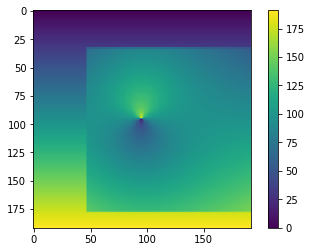

In [24]:
plt.imshow( fx[0][0,:,:,0])
plt.colorbar()

In [28]:
np.max(fy[0])

191.0

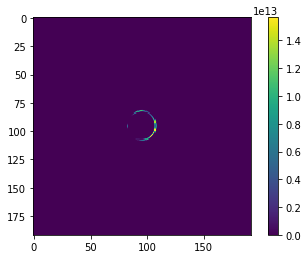

In [39]:
plt.imshow(imout[0,:,:,0])
plt.colorbar()

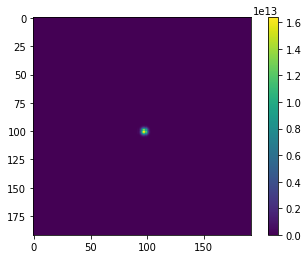

In [40]:
plt.imshow(source[0,:,:,0])
plt.colorbar()

In [94]:
np.save('convkernelX.npy', convkerx[:,:,0,0])
np.save('kappa.npy', kap[0,:,:,0])

In [14]:
np.save('imout.npy', imout[0,:,:,0])

In [ ]:
from astropy.io import fits

In [ ]:
hdul = fits.open('source.fits')
hdu2 = fits.open('kappa.fits')
source = hdul[0].data
kappa = hdu2[0].data
hdul.close()
hdu2.close()

In [ ]:
data = hdul[0].data

In [ ]:
plt.imshow(np.log10(kappa[0,:,:,0]))

In [ ]:
 hdul.close()

In [ ]:
data.shape

In [58]:
a = tf.Variable(tf.zeros(shape=(2, 3, 4)))
print("a v1", tf.shape(a))
print("a v2", a.shape.as_list())

('a v1', <tf.Tensor 'Shape_3:0' shape=(3,) dtype=int32>)
('a v2', [2, 3, 4])


In [60]:
(a.shape.as_list())[2]

4

In [56]:
print("a v3", sess.run(tf.shape(a)))

('a v3', array([2, 3, 4], dtype=int32))


In [88]:
IM = tf.constant([1, 2, 3, 4, 5, 6, 7,8,9,10,11,12,13,14,15,16], shape = [1, 4, 4,1] )
mult = tf.constant([5,1,1,1] )
x = tf.placeholder(tf.float32, shape=[None, 4,4,1])


b1 = tf.shape(x)[0:1]
b2 = (x.shape.as_list())[1]

a = tf.constant([(x.shape.as_list())[1], 1, 1, 1])

tiled = tf.manip.tile(IM, a)

A = tf.constant(1)
Amult = tf.stack([tf.shape(x)[0], A,A,A])
y = tf.tile(IM, Amult)

sess = tf.Session()
y = sess.run(y, feed_dict={x: np.zeros([11, 4,4,1])})
print y
#til =  sess.run(tiled)




[[[[ 1]
   [ 2]
   [ 3]
   [ 4]]

  [[ 5]
   [ 6]
   [ 7]
   [ 8]]

  [[ 9]
   [10]
   [11]
   [12]]

  [[13]
   [14]
   [15]
   [16]]]


 [[[ 1]
   [ 2]
   [ 3]
   [ 4]]

  [[ 5]
   [ 6]
   [ 7]
   [ 8]]

  [[ 9]
   [10]
   [11]
   [12]]

  [[13]
   [14]
   [15]
   [16]]]


 [[[ 1]
   [ 2]
   [ 3]
   [ 4]]

  [[ 5]
   [ 6]
   [ 7]
   [ 8]]

  [[ 9]
   [10]
   [11]
   [12]]

  [[13]
   [14]
   [15]
   [16]]]


 [[[ 1]
   [ 2]
   [ 3]
   [ 4]]

  [[ 5]
   [ 6]
   [ 7]
   [ 8]]

  [[ 9]
   [10]
   [11]
   [12]]

  [[13]
   [14]
   [15]
   [16]]]


 [[[ 1]
   [ 2]
   [ 3]
   [ 4]]

  [[ 5]
   [ 6]
   [ 7]
   [ 8]]

  [[ 9]
   [10]
   [11]
   [12]]

  [[13]
   [14]
   [15]
   [16]]]


 [[[ 1]
   [ 2]
   [ 3]
   [ 4]]

  [[ 5]
   [ 6]
   [ 7]
   [ 8]]

  [[ 9]
   [10]
   [11]
   [12]]

  [[13]
   [14]
   [15]
   [16]]]


 [[[ 1]
   [ 2]
   [ 3]
   [ 4]]

  [[ 5]
   [ 6]
   [ 7]
   [ 8]]

  [[ 9]
   [10]
   [11]
   [12]]

  [[13]
   [14]
   [15]
   [16]]]


 [[[ 1]
   [ 2]
   [ 3]
   [ 4]]



In [92]:
print y[1,:,:,0]

[[ 1  2  3  4]
 [ 5  6  7  8]
 [ 9 10 11 12]
 [13 14 15 16]]
